In [2]:
import pandas as pd
import seaborn as sns
import torch
from train import train
from utils.training import make_stats_df, TrainConfig

In [9]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Plan

## Data

1. Years: 2018–2022.
2. Each year: N fields.
3. Each field:
  - features: time series of 10 Sentinel-2 bands (median value for each field), number of timestamps is different;
  - target: crop class label (13 classes).

## Models

1. Classical ML:
  - Random Forest;
  - Catboost;
  - LightGBM.
2. Deep learning:
  - Transformer;
  - TempCNN;
  - *EarlyRNN*.
 
## Training&evaluation workflow

1. For all models besides EarlyRNN: make datasets of reduced size (1–6 months, where 6 months is full-length time series), train models separately on each of them.
2. For EarlyRNN: train using full-length time series.
3. Compare accuracy, precision, recall, f1-score, kappa.

# Part 1: Classical Machine Learning

## Random Forest

In [3]:
rf_stats_with_geo = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="rf",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"n_estimators": range(10, 110, 20)},
                       geo=True)
    best_model, train_stats = train(args)
    rf_stats_with_geo.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 27914 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7432 fields
X shape: (27914, 120) y shape: (27914,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [5]:
rf_stats_df_with_geo = make_stats_df(rf_stats_with_geo)

<AxesSubplot: xlabel='n_months'>

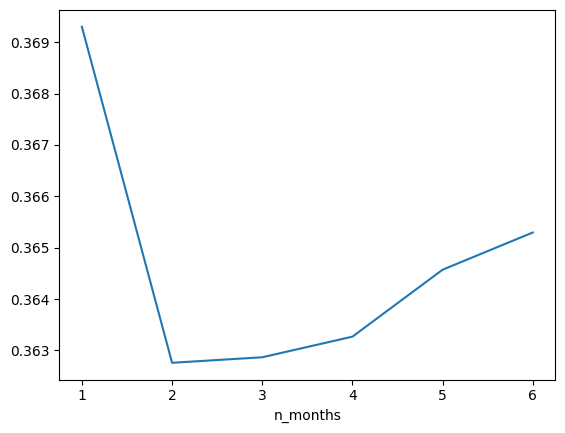

[CV] END ....................................n_estimators=10; total time=   4.3s
[CV] END ....................................n_estimators=10; total time=   4.2s
[CV] END ....................................n_estimators=30; total time=  12.0s
[CV] END ....................................n_estimators=50; total time=  19.8s
[CV] END ....................................n_estimators=50; total time=  19.1s
[CV] END ....................................n_estimators=70; total time=  31.8s
[CV] END ....................................n_estimators=70; total time=  31.7s
[CV] END ....................................n_estimators=90; total time=  34.7s
[CV] END ....................................n_estimators=10; total time=   5.2s
[CV] END ....................................n_estimators=10; total time=   4.8s
[CV] END ....................................n_estimators=30; total time=  17.7s
[CV] END ....................................n_estimators=30; total time=  19.9s
[CV] END ...................

In [6]:
rf_stats_df_with_geo.groupby("n_months")["mean_test_accuracy"].mean().plot()

In [21]:
rf_dfs = []
for i, stat in enumerate(rf_stats):
    df = pd.DataFrame(stat)
    df["n_months"] = i + 1
    rf_dfs.append(df)
rf_stat_df = pd.concat(rf_dfs)
rf_stat_df.reset_index(drop=True, inplace=True)

In [22]:
rf_stat_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,split3_test_kappa,split4_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa,n_months
0,5.530161,0.536271,0.053766,0.004011,10,{'n_estimators': 10},0.516437,0.533531,0.535427,0.518823,...,5,0.434456,0.455954,0.453075,0.434335,0.443335,0.444231,0.009055,5,1
1,17.307498,1.239440,0.121411,0.007994,30,{'n_estimators': 30},0.567061,0.583333,0.579813,0.565839,...,4,0.492100,0.512435,0.503674,0.487696,0.503190,0.499819,0.008854,4,1
2,26.955016,3.128957,0.178361,0.025497,50,{'n_estimators': 50},0.583498,0.592045,0.590334,0.586060,...,3,0.511208,0.522253,0.516077,0.511640,0.523168,0.516869,0.005073,3,1
3,40.585612,4.652533,0.208319,0.021689,70,{'n_estimators': 70},0.588264,0.600756,0.601184,0.589347,...,1,0.516186,0.532388,0.528745,0.515077,0.527616,0.524002,0.007023,1,1
4,41.468254,6.151401,0.256024,0.032987,90,{'n_estimators': 90},0.592373,0.597962,0.597238,0.591156,...,2,0.521004,0.528986,0.523690,0.516920,0.523799,0.522880,0.003946,2,1
5,7.078377,0.816084,0.051993,0.006682,10,{'n_estimators': 10},0.575937,0.587114,0.592964,0.585566,...,5,0.505767,0.519083,0.522750,0.513864,0.512201,0.514733,0.005844,5,2
6,21.323907,2.623709,0.109219,0.013138,30,{'n_estimators': 30},0.617357,0.625904,0.639816,0.626336,...,4,0.552271,0.562799,0.576646,0.560217,0.554982,0.561383,0.008489,4,2
7,36.277406,4.429330,0.164226,0.016719,50,{'n_estimators': 50},0.634287,0.647272,0.648529,0.646227,...,3,0.571806,0.587935,0.586828,0.583978,0.572795,0.580668,0.006961,3,2
8,49.724756,6.115824,0.229821,0.019663,70,{'n_estimators': 70},0.636259,0.648751,0.652474,0.650337,...,2,0.574069,0.589371,0.591202,0.588727,0.578045,0.584283,0.006881,2,2
9,60.738212,8.817731,0.249882,0.025376,90,{'n_estimators': 90},0.645135,0.644806,0.655104,0.652310,...,1,0.584666,0.584755,0.594411,0.590973,0.578874,0.586736,0.005420,1,2


<AxesSubplot: xlabel='n_months'>

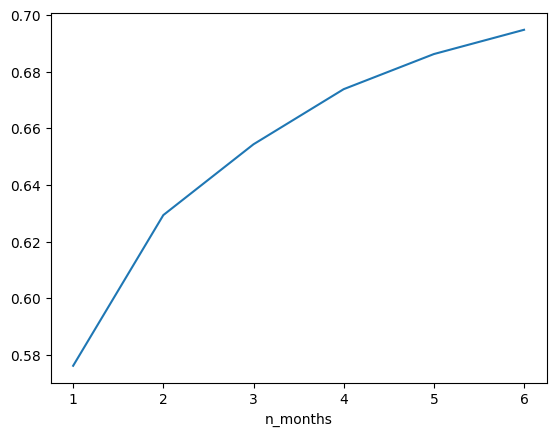

In [24]:
rf_stat_df.groupby("n_months")["mean_test_accuracy"].mean().plot()

In [3]:
lgbm_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="lightgbm",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"n_estimators": range(10, 110, 20)})
    best_model, train_stats = train(args)
    lgbm_stats.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
X shape: (30417, 100) y shape: (30417,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
X shape: (30417, 200) y shape: (30417,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Cache is activated

In [7]:
lgbm_stats_df = make_stats_df(lgbm_stats)
lgbm_stats_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,split3_test_kappa,split4_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa,n_months
0,7.068616,0.960297,0.096660,0.013189,10,{'n_estimators': 10},0.566897,0.577909,0.578662,0.567812,...,5,0.488175,0.502188,0.499913,0.487513,0.498799,0.495318,0.006203,5,1
1,20.578785,2.244071,0.288416,0.033782,30,{'n_estimators': 30},0.618179,0.624425,0.626829,0.623541,...,4,0.553254,0.561589,0.560831,0.557703,0.558101,0.558295,0.002936,4,1
2,32.855013,5.636224,0.509417,0.058264,50,{'n_estimators': 50},0.639875,0.638396,0.643268,0.636035,...,3,0.579283,0.578216,0.580796,0.572666,0.572785,0.576749,0.003387,3,1
3,46.684939,9.189653,0.773902,0.097560,70,{'n_estimators': 70},0.646450,0.645135,0.654447,0.641624,...,2,0.586945,0.586066,0.594159,0.579109,0.584009,0.586058,0.004877,2,1
4,55.669773,10.903128,0.992248,0.213136,90,{'n_estimators': 90},0.651052,0.650230,0.658885,0.640967,...,1,0.592245,0.591978,0.599291,0.578159,0.585417,0.589418,0.007139,1,1
5,14.159917,2.871397,0.102668,0.019355,10,{'n_estimators': 10},0.609303,0.622452,0.624692,0.616801,...,5,0.539808,0.556443,0.555963,0.547074,0.546246,0.549107,0.006318,5,2
6,40.142370,8.030832,0.288801,0.037183,30,{'n_estimators': 30},0.660256,0.671598,0.678119,0.666447,...,4,0.603444,0.617266,0.622304,0.608757,0.608699,0.612094,0.006760,4,2
7,65.863582,13.236515,0.501765,0.068322,50,{'n_estimators': 50},0.680145,0.683103,0.694065,0.680914,...,3,0.626965,0.631018,0.641518,0.626089,0.629087,0.630935,0.005562,3,2
8,91.752167,18.756827,0.742485,0.093852,70,{'n_estimators': 70},0.684747,0.689513,0.701134,0.684695,...,2,0.632292,0.638478,0.649977,0.630475,0.640321,0.638308,0.006896,2,2
9,104.425520,20.760293,0.970121,0.276991,90,{'n_estimators': 90},0.691321,0.691486,0.704751,0.689134,...,1,0.640190,0.640689,0.654106,0.635620,0.640593,0.642240,0.006228,1,2


<AxesSubplot: xlabel='n_months'>

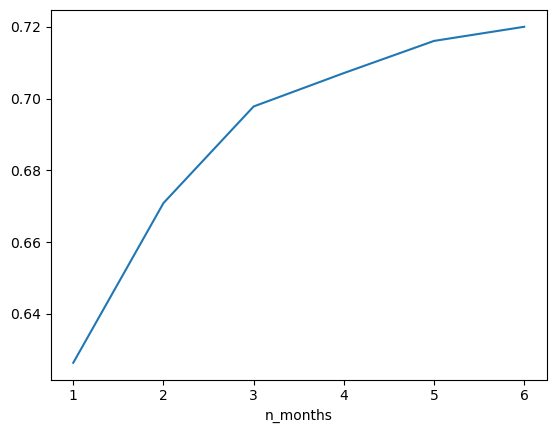

In [8]:
lgbm_stats_df.groupby("n_months")["mean_test_accuracy"].mean().plot()

In [4]:
catboost_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="catboost",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"iterations": range(10, 60, 20)})
    best_model, train_stats = train(args)
    catboost_stats.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
X shape: (30417, 100) y shape: (30417,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.5
0:	learn: 2.0040908	total: 1.54s	remaining: 13.9s
1:	learn: 1.8169580	total: 3.04s	remaining: 12.2s
2:	learn: 1.7041924	total: 5.1s	remaining: 11.9s
3:	learn: 1.6296813	total: 6.95s	remaining: 10.4s
4:	learn: 1.5681955	total: 8.59s	remaining: 8.59s
5:	learn: 1.5193948	total: 10.4s	remaining: 6.94s
6:	learn: 1.4760541	total: 11.8s	remaining: 5.07s
7:	learn: 1.4360259	total: 13.2s	remaining: 3.29s
8:	learn: 1.4113065	total: 14.5s	remaining: 1.61s
9:	learn: 1.3880715	total: 15.4s	re

Learning rate set to 0.5
0:	learn: 1.9849325	total: 574ms	remaining: 28.1s
1:	learn: 1.8170465	total: 1.09s	remaining: 26.2s
2:	learn: 1.7096229	total: 1.59s	remaining: 24.9s
3:	learn: 1.6292102	total: 2.12s	remaining: 24.4s
4:	learn: 1.5776012	total: 2.63s	remaining: 23.6s
5:	learn: 1.5282354	total: 3.14s	remaining: 23s
6:	learn: 1.4901635	total: 3.64s	remaining: 22.4s
7:	learn: 1.4537874	total: 4.16s	remaining: 21.8s
8:	learn: 1.4241414	total: 4.67s	remaining: 21.3s
9:	learn: 1.3996810	total: 5.18s	remaining: 20.7s
10:	learn: 1.3773601	total: 5.69s	remaining: 20.2s
11:	learn: 1.3579346	total: 6.2s	remaining: 19.6s
12:	learn: 1.3411379	total: 6.7s	remaining: 19.1s
13:	learn: 1.3115833	total: 7.22s	remaining: 18.6s
14:	learn: 1.2968588	total: 7.73s	remaining: 18s
15:	learn: 1.2796845	total: 8.25s	remaining: 17.5s
16:	learn: 1.2620818	total: 8.75s	remaining: 17s
17:	learn: 1.2487943	total: 9.26s	remaining: 16.5s
18:	learn: 1.2384812	total: 9.75s	remaining: 15.9s
19:	learn: 1.2249816	tot

Learning rate set to 0.5
0:	learn: 1.9929092	total: 1.52s	remaining: 13.7s
1:	learn: 1.8130525	total: 3s	remaining: 12s
2:	learn: 1.7018927	total: 4.48s	remaining: 10.5s
3:	learn: 1.6179105	total: 6.35s	remaining: 9.53s
4:	learn: 1.5651575	total: 8.06s	remaining: 8.06s
5:	learn: 1.5060503	total: 9.8s	remaining: 6.53s
6:	learn: 1.4726235	total: 11.3s	remaining: 4.82s
7:	learn: 1.4336992	total: 12.7s	remaining: 3.17s
8:	learn: 1.4090501	total: 14.1s	remaining: 1.56s
9:	learn: 1.3890962	total: 15.4s	remaining: 0us
[CV] END ......................................iterations=10; total time=  18.9s
Learning rate set to 0.5
0:	learn: 1.9968339	total: 836ms	remaining: 7.52s
1:	learn: 1.7974328	total: 2.29s	remaining: 9.16s
2:	learn: 1.6965597	total: 4.24s	remaining: 9.88s
3:	learn: 1.6141776	total: 5.89s	remaining: 8.83s
4:	learn: 1.5582791	total: 7.61s	remaining: 7.61s
5:	learn: 1.5144599	total: 9.17s	remaining: 6.11s
6:	learn: 1.4769744	total: 10.9s	remaining: 4.66s
7:	learn: 1.4426248	total: 

Learning rate set to 0.5
0:	learn: 1.9201777	total: 1.01s	remaining: 49.6s
1:	learn: 1.7168018	total: 2.02s	remaining: 48.4s
2:	learn: 1.5800666	total: 3.03s	remaining: 47.5s
3:	learn: 1.5037359	total: 4.04s	remaining: 46.5s
4:	learn: 1.4461025	total: 5.04s	remaining: 45.4s
5:	learn: 1.4010662	total: 6.04s	remaining: 44.3s
6:	learn: 1.3529519	total: 7.03s	remaining: 43.2s
7:	learn: 1.3190520	total: 8.05s	remaining: 42.2s
8:	learn: 1.2879479	total: 9.08s	remaining: 41.4s
9:	learn: 1.2617234	total: 10.1s	remaining: 40.4s
10:	learn: 1.2402049	total: 11.1s	remaining: 39.4s
11:	learn: 1.2197064	total: 12.1s	remaining: 38.3s
12:	learn: 1.1971662	total: 13.1s	remaining: 37.3s
13:	learn: 1.1755631	total: 14.1s	remaining: 36.2s
14:	learn: 1.1579703	total: 15.1s	remaining: 35.3s
15:	learn: 1.1460952	total: 16.1s	remaining: 34.2s
16:	learn: 1.1294653	total: 17.1s	remaining: 33.2s
17:	learn: 1.1139870	total: 18.1s	remaining: 32.2s
18:	learn: 1.0973126	total: 19.1s	remaining: 31.2s
19:	learn: 1.084

[CV] END ......................................iterations=10; total time=  29.6s
Learning rate set to 0.5
0:	learn: 1.9011608	total: 2.64s	remaining: 1m 16s
1:	learn: 1.7150399	total: 5.26s	remaining: 1m 13s
2:	learn: 1.6061863	total: 7.9s	remaining: 1m 11s
3:	learn: 1.5138167	total: 10.6s	remaining: 1m 8s
4:	learn: 1.4601928	total: 13.3s	remaining: 1m 6s
5:	learn: 1.3957954	total: 16s	remaining: 1m 3s
6:	learn: 1.3605538	total: 18.5s	remaining: 1m
7:	learn: 1.3264461	total: 21.2s	remaining: 58.4s
8:	learn: 1.2992102	total: 23.8s	remaining: 55.6s
9:	learn: 1.2776224	total: 26.5s	remaining: 53s
10:	learn: 1.2536086	total: 29.2s	remaining: 50.4s
11:	learn: 1.2275485	total: 31.7s	remaining: 47.6s
12:	learn: 1.2034675	total: 34.4s	remaining: 45s
13:	learn: 1.1850875	total: 37.1s	remaining: 42.4s
14:	learn: 1.1602562	total: 39.8s	remaining: 39.8s
15:	learn: 1.1397652	total: 42.6s	remaining: 37.3s
16:	learn: 1.1286371	total: 45.4s	remaining: 34.7s
17:	learn: 1.1117180	total: 47.9s	remaining:

3:	learn: 1.4687633	total: 15.9s	remaining: 23.8s
4:	learn: 1.4178622	total: 19.9s	remaining: 19.9s
5:	learn: 1.3412067	total: 23.9s	remaining: 15.9s
6:	learn: 1.2970392	total: 27.9s	remaining: 12s
7:	learn: 1.2625458	total: 31.4s	remaining: 7.84s
8:	learn: 1.2317983	total: 34.2s	remaining: 3.8s
9:	learn: 1.2112927	total: 36.9s	remaining: 0us
[CV] END ......................................iterations=10; total time=  46.7s
Learning rate set to 0.5
0:	learn: 1.8413944	total: 4.07s	remaining: 1m 58s
1:	learn: 1.6646628	total: 8.22s	remaining: 1m 55s
2:	learn: 1.5512722	total: 12.2s	remaining: 1m 49s
3:	learn: 1.4687633	total: 16.2s	remaining: 1m 45s
4:	learn: 1.4178622	total: 20.2s	remaining: 1m 41s
5:	learn: 1.3412067	total: 24.4s	remaining: 1m 37s
6:	learn: 1.2970392	total: 28.2s	remaining: 1m 32s
7:	learn: 1.2625458	total: 31.1s	remaining: 1m 25s
8:	learn: 1.2317983	total: 32.9s	remaining: 1m 16s
9:	learn: 1.2112927	total: 34.8s	remaining: 1m 9s
10:	learn: 1.1880526	total: 36.7s	remain

1:	learn: 1.6493931	total: 3s	remaining: 1m 12s
2:	learn: 1.5617590	total: 4.42s	remaining: 1m 9s
3:	learn: 1.4937165	total: 5.88s	remaining: 1m 7s
4:	learn: 1.4356032	total: 7.31s	remaining: 1m 5s
5:	learn: 1.3582505	total: 8.82s	remaining: 1m 4s
6:	learn: 1.3185611	total: 10.4s	remaining: 1m 3s
7:	learn: 1.2744265	total: 11.9s	remaining: 1m 2s
8:	learn: 1.2505814	total: 13.4s	remaining: 1m
9:	learn: 1.2281810	total: 14.8s	remaining: 59.3s
10:	learn: 1.2000637	total: 16.3s	remaining: 57.8s
11:	learn: 1.1807319	total: 17.7s	remaining: 56.2s
12:	learn: 1.1668582	total: 19.2s	remaining: 54.6s
13:	learn: 1.1462955	total: 20.7s	remaining: 53.1s
14:	learn: 1.1225611	total: 22.2s	remaining: 51.8s
15:	learn: 1.1015675	total: 23.7s	remaining: 50.3s
16:	learn: 1.0835274	total: 25.1s	remaining: 48.8s
17:	learn: 1.0697780	total: 26.6s	remaining: 47.3s
18:	learn: 1.0526795	total: 28.1s	remaining: 45.9s
19:	learn: 1.0367473	total: 29.6s	remaining: 44.4s
20:	learn: 1.0200382	total: 31.1s	remaining: 

33:	learn: 0.8550242	total: 1m 56s	remaining: 54.9s
34:	learn: 0.8472071	total: 1m 59s	remaining: 51s
35:	learn: 0.8423392	total: 2m 1s	remaining: 47.3s
36:	learn: 0.8367571	total: 2m 4s	remaining: 43.6s
37:	learn: 0.8261340	total: 2m 6s	remaining: 40s
38:	learn: 0.8209311	total: 2m 9s	remaining: 36.5s
39:	learn: 0.8102057	total: 2m 12s	remaining: 33s
40:	learn: 0.8001163	total: 2m 14s	remaining: 29.6s
41:	learn: 0.7931429	total: 2m 17s	remaining: 26.1s
42:	learn: 0.7866315	total: 2m 19s	remaining: 22.7s
43:	learn: 0.7831509	total: 2m 22s	remaining: 19.4s
44:	learn: 0.7786484	total: 2m 24s	remaining: 16.1s
45:	learn: 0.7718463	total: 2m 27s	remaining: 12.8s
46:	learn: 0.7668596	total: 2m 29s	remaining: 9.56s
47:	learn: 0.7625572	total: 2m 32s	remaining: 6.35s
48:	learn: 0.7562877	total: 2m 34s	remaining: 3.16s
49:	learn: 0.7506020	total: 2m 37s	remaining: 0us
[CV] END ......................................iterations=50; total time= 2.9min
Learning rate set to 0.5
0:	learn: 1.8198931	to

Learning rate set to 0.5
0:	learn: 1.8241844	total: 1.94s	remaining: 1m 34s
1:	learn: 1.6397491	total: 3.89s	remaining: 1m 33s
2:	learn: 1.5250038	total: 5.78s	remaining: 1m 30s
3:	learn: 1.4391223	total: 7.73s	remaining: 1m 28s
4:	learn: 1.3693345	total: 9.7s	remaining: 1m 27s
5:	learn: 1.3231235	total: 11.6s	remaining: 1m 24s
6:	learn: 1.2737164	total: 13.6s	remaining: 1m 23s
7:	learn: 1.2312301	total: 15.5s	remaining: 1m 21s
8:	learn: 1.1979707	total: 17.5s	remaining: 1m 19s
9:	learn: 1.1707689	total: 19.3s	remaining: 1m 17s
10:	learn: 1.1449842	total: 21.2s	remaining: 1m 15s
11:	learn: 1.1243924	total: 23.2s	remaining: 1m 13s
12:	learn: 1.1088058	total: 25.1s	remaining: 1m 11s
13:	learn: 1.0884317	total: 27s	remaining: 1m 9s
14:	learn: 1.0703769	total: 29s	remaining: 1m 7s
15:	learn: 1.0549831	total: 30.9s	remaining: 1m 5s
16:	learn: 1.0416846	total: 32.8s	remaining: 1m 3s
17:	learn: 1.0224247	total: 34.7s	remaining: 1m 1s
18:	learn: 1.0028800	total: 36.7s	remaining: 59.8s
19:	lear

12:	learn: 1.0975530	total: 51.4s	remaining: 2m 26s
13:	learn: 1.0741208	total: 55s	remaining: 2m 21s
14:	learn: 1.0576648	total: 58.3s	remaining: 2m 16s
15:	learn: 1.0416102	total: 1m 1s	remaining: 2m 11s
16:	learn: 1.0239551	total: 1m 5s	remaining: 2m 6s
17:	learn: 1.0115031	total: 1m 8s	remaining: 2m 1s
18:	learn: 0.9913051	total: 1m 12s	remaining: 1m 57s
19:	learn: 0.9782673	total: 1m 15s	remaining: 1m 53s
20:	learn: 0.9616309	total: 1m 19s	remaining: 1m 49s
21:	learn: 0.9453296	total: 1m 22s	remaining: 1m 45s
22:	learn: 0.9336615	total: 1m 25s	remaining: 1m 40s
23:	learn: 0.9237586	total: 1m 29s	remaining: 1m 36s
24:	learn: 0.9116211	total: 1m 32s	remaining: 1m 32s
25:	learn: 0.9039656	total: 1m 36s	remaining: 1m 28s
26:	learn: 0.8942423	total: 1m 39s	remaining: 1m 24s
27:	learn: 0.8803932	total: 1m 42s	remaining: 1m 20s
28:	learn: 0.8739280	total: 1m 46s	remaining: 1m 16s
29:	learn: 0.8614905	total: 1m 48s	remaining: 1m 12s
30:	learn: 0.8492114	total: 1m 50s	remaining: 1m 7s
31:	

Learning rate set to 0.5
0:	learn: 1.8018134	total: 2.4s	remaining: 1m 57s
1:	learn: 1.5949555	total: 4.85s	remaining: 1m 56s
2:	learn: 1.4891652	total: 7.34s	remaining: 1m 55s
3:	learn: 1.4096194	total: 9.81s	remaining: 1m 52s
4:	learn: 1.3598484	total: 12.1s	remaining: 1m 48s
5:	learn: 1.2880169	total: 14.5s	remaining: 1m 46s
6:	learn: 1.2438068	total: 17s	remaining: 1m 44s
7:	learn: 1.1963766	total: 19.5s	remaining: 1m 42s
8:	learn: 1.1667798	total: 21.8s	remaining: 1m 39s
9:	learn: 1.1468813	total: 24.2s	remaining: 1m 36s
10:	learn: 1.1207439	total: 26.6s	remaining: 1m 34s
11:	learn: 1.0977846	total: 28.9s	remaining: 1m 31s
12:	learn: 1.0717538	total: 31.4s	remaining: 1m 29s
13:	learn: 1.0514355	total: 33.7s	remaining: 1m 26s
14:	learn: 1.0283734	total: 36.1s	remaining: 1m 24s
15:	learn: 1.0095159	total: 38.7s	remaining: 1m 22s
16:	learn: 0.9983432	total: 41s	remaining: 1m 19s
17:	learn: 0.9811464	total: 43.5s	remaining: 1m 17s
18:	learn: 0.9688020	total: 45.9s	remaining: 1m 14s
19

11:	learn: 1.0832476	total: 1m 18s	remaining: 4m 7s
12:	learn: 1.0659321	total: 1m 24s	remaining: 3m 59s
13:	learn: 1.0463854	total: 1m 30s	remaining: 3m 53s
14:	learn: 1.0240723	total: 1m 35s	remaining: 3m 42s
15:	learn: 1.0091662	total: 1m 40s	remaining: 3m 32s
16:	learn: 0.9939781	total: 1m 44s	remaining: 3m 23s
17:	learn: 0.9772622	total: 1m 49s	remaining: 3m 14s
18:	learn: 0.9639482	total: 1m 54s	remaining: 3m 6s
19:	learn: 0.9471697	total: 1m 59s	remaining: 2m 58s
20:	learn: 0.9351213	total: 2m 4s	remaining: 2m 52s
21:	learn: 0.9177789	total: 2m 11s	remaining: 2m 47s
22:	learn: 0.9085255	total: 2m 16s	remaining: 2m 39s
23:	learn: 0.8881608	total: 2m 20s	remaining: 2m 32s
24:	learn: 0.8782125	total: 2m 25s	remaining: 2m 25s
25:	learn: 0.8667101	total: 2m 29s	remaining: 2m 17s
26:	learn: 0.8462380	total: 2m 33s	remaining: 2m 10s
27:	learn: 0.8366978	total: 2m 37s	remaining: 2m 3s
28:	learn: 0.8247682	total: 2m 41s	remaining: 1m 57s
29:	learn: 0.8123466	total: 2m 46s	remaining: 1m 5

Learning rate set to 0.5
0:	learn: 1.7706639	total: 2.88s	remaining: 2m 21s
1:	learn: 1.5939940	total: 5.76s	remaining: 2m 18s
2:	learn: 1.4789210	total: 8.62s	remaining: 2m 15s
3:	learn: 1.4007169	total: 11.6s	remaining: 2m 13s
4:	learn: 1.3107687	total: 14.6s	remaining: 2m 11s
5:	learn: 1.2599663	total: 17.6s	remaining: 2m 8s
6:	learn: 1.2208768	total: 20.5s	remaining: 2m 5s
7:	learn: 1.1820238	total: 23.4s	remaining: 2m 2s
8:	learn: 1.1525326	total: 26.3s	remaining: 1m 59s
9:	learn: 1.1331569	total: 29.1s	remaining: 1m 56s
10:	learn: 1.1094910	total: 32s	remaining: 1m 53s
11:	learn: 1.0866753	total: 34.8s	remaining: 1m 50s
12:	learn: 1.0597010	total: 37.7s	remaining: 1m 47s
13:	learn: 1.0395910	total: 40.7s	remaining: 1m 44s
14:	learn: 1.0227434	total: 43.5s	remaining: 1m 41s
15:	learn: 1.0012937	total: 46.4s	remaining: 1m 38s
16:	learn: 0.9880886	total: 49.3s	remaining: 1m 35s
17:	learn: 0.9711087	total: 52.2s	remaining: 1m 32s
18:	learn: 0.9575697	total: 55.1s	remaining: 1m 29s
19

In [5]:
catboost_stats_df = make_stats_df(catboost_stats)
catboost_stats_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,split3_test_kappa,split4_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa,n_months
0,18.205189,0.403044,0.743364,0.238470,10,{'iterations': 10},0.500657,0.503780,0.532796,0.514220,...,3,0.414603,0.420591,0.450204,0.428346,0.416260,0.426001,0.013003,3,1
1,45.429399,3.468222,0.788702,0.170041,30,{'iterations': 30},0.566404,0.571335,0.588690,0.574552,...,2,0.493884,0.500444,0.516920,0.500923,0.492581,0.500950,0.008663,2,1
2,60.575596,10.049244,0.737310,0.322572,50,{'iterations': 50},0.590894,0.594017,0.606280,0.589183,...,1,0.523325,0.527522,0.538239,0.518321,0.521913,0.525864,0.006853,1,1
3,28.367606,1.600699,1.484199,0.530879,10,{'iterations': 10},0.540434,0.538297,0.561894,0.548742,...,3,0.463558,0.461812,0.484930,0.470920,0.484907,0.473225,0.010025,3,2
4,80.824549,0.500514,1.832976,0.403077,30,{'iterations': 30},0.601578,0.614234,0.620582,0.619596,...,2,0.535753,0.551772,0.556139,0.554797,0.552735,0.550239,0.007403,2,2


<AxesSubplot: xlabel='n_months'>

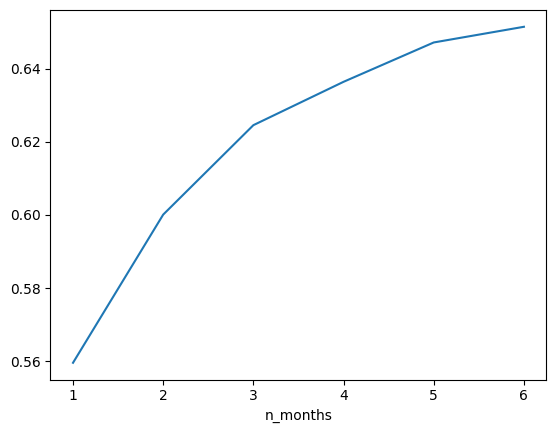

In [7]:
catboost_stats_df.groupby("n_months")["mean_test_accuracy"].mean().plot()

In [8]:
xgb_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="xgboost",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"n_estimators": range(10, 60, 20)})
    best_model, train_stats = train(args)
    xgb_stats.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
X shape: (30417, 100) y shape: (30417,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=10; total time= 2.3min
[CV] END ....................................n_estimators=10; total time= 2.3min
[CV] END ....................................n_estimators=30; total time= 6.4min
[CV] END ....................................n_estimators=30; total time= 6.6min
[CV] END ....................................n_estimators=50; total time=10.3min
[CV] END ....................................n_estimators=10; total time= 2.1min
[CV] END ..............

KeyboardInterrupt: 

In [15]:
df = pd.read_csv("/home/pavel/elects_data/russia/fields_centers.csv")
df

,field_id,lat,lon
0,2591,51.267659,36.528691
1,2592,51.259333,36.532375
2,2593,51.269374,36.539640
3,2594,51.267585,36.584381
4,2595,51.277446,36.576018
...,...,...,...
55777,102446,45.886803,41.093875
55778,102447,45.868723,41.088664
55779,102448,45.868384,41.087447
55780,102449,45.917341,41.040451


In [16]:
feat = pd.read_csv("/home/pavel/elects_data/russia/russia-2021/train_features.csv.zip")

In [18]:
feat

,index,timestamp,field_id,eopatch,parcel_pixels,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,parcell_cloud_coverage,parcell_data_coverage,class_id
0,0,2021-04-01,2591,37UCS_2_1,856,440.0,389.0,437.50,470.0,475.0,509.00,561.00,565.0,988.0,793.5,0.450025,0.522777,0
1,1,2021-04-06,2591,37UCS_2_1,6151,211.0,277.0,402.00,474.0,511.0,567.00,656.00,689.0,1766.0,1633.0,0.000000,0.522777,0
2,2,2021-04-11,2591,37UCS_2_1,6151,297.0,323.0,457.00,517.0,563.0,630.00,749.00,767.0,1991.0,1913.0,0.000000,0.522777,0
3,3,2021-05-01,2591,37UCS_2_1,6151,471.0,484.0,600.00,694.0,774.0,865.00,983.00,1030.0,2411.0,2295.0,0.000000,0.522777,0
4,4,2021-05-16,2591,37UCS_2_1,5545,317.0,337.0,256.00,371.0,645.0,674.00,678.00,702.0,711.0,533.0,0.051504,0.522777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837195,1007860,2021-07-10,89301,37UDA_6_2,0,769.5,1010.5,812.25,1364.0,3144.5,3647.75,3742.75,3869.5,2503.0,1634.0,0.475219,0.475219,3
837196,1007861,2021-07-20,89301,37UDA_6_2,388,834.0,1049.0,802.50,1341.0,3307.0,3858.50,3925.50,4045.0,2399.0,1475.0,0.098154,0.475219,3
837197,1007862,2021-08-09,89301,37UDA_6_2,489,498.0,893.0,576.00,1336.0,3212.0,3717.00,3771.00,3878.0,2244.0,1275.0,0.000000,0.475219,3
837198,1007863,2021-08-14,89301,37UDA_6_2,489,531.0,941.0,542.00,1410.0,3340.0,3713.00,3892.00,3899.0,2137.0,1117.0,0.000000,0.475219,3


In [46]:
feat.merge(df, how="left")[["lat", "lon"]].to_numpy()[0, :].reshape((1, -1)).repeat(10, axis=0)

array([[51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053],
       [51.26765856, 36.52869053]])

In [23]:
feat[["lat", "lon"]].to_numpy()

KeyError: "None of [Index(['lat', 'lon'], dtype='object')] are in the [columns]"

In [13]:
df.drop_duplicates("field_id").to_csv("fields_centers.csv", index=False)

In [10]:
xgb_stats_df = make_stats_df(xgb_stats)
xgb_stats_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,split3_test_kappa,split4_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa,n_months
0,101.138748,23.891061,0.072919,0.013951,10,{'n_estimators': 10},0.584648,0.600099,0.612527,0.586553,...,5,0.512208,0.532117,0.543131,0.513452,0.523709,0.524923,0.011645,5,1
1,283.333891,44.534308,0.153131,0.028287,30,{'n_estimators': 30},0.627383,0.623603,0.644583,0.623541,...,4,0.563778,0.560802,0.582167,0.558388,0.568498,0.566727,0.008425,4,1
2,463.666269,79.519657,0.217434,0.043962,50,{'n_estimators': 50},0.641847,0.637738,0.656584,0.630610,...,3,0.581083,0.577390,0.596458,0.566626,0.577588,0.579829,0.009627,3,1
3,703.735514,98.310059,0.346516,0.049095,70,{'n_estimators': 70},0.648915,0.647436,0.659379,0.634720,...,2,0.589210,0.588614,0.599706,0.571360,0.585332,0.586844,0.009124,2,1
4,759.673512,65.202875,0.369720,0.078572,90,{'n_estimators': 90},0.654668,0.652038,0.662338,0.643104,...,1,0.595927,0.593942,0.602999,0.581197,0.593730,0.593559,0.007039,1,1


In [3]:
transformer_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(epochs=25,
                       model="transformer",
                       n_months=n_months,
                       sequencelength=sequencelength)
    best_model, train_stats = train(args)
    transformer_stats.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([10, 10]) y shape: torch.Size([])


/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU0 GeForce GT 740M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
epoch 25: trainloss 1.24, testloss 1.24, accuracy 0.60, earliness 0.00. classification loss 1.24, earliness reward 0.00. saving model t


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.92, testloss 0.98, accuracy 0.70, earliness 0.00. classification loss 0.98, earliness reward 0.00. saving model t


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.77, testloss 0.88, accuracy 0.74, earliness 0.00. classification loss 0.88, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.71, testloss 0.85, accuracy 0.76, earliness 0.00. classification loss 0.85, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.68, testloss 0.82, accuracy 0.77, earliness 0.00. classification loss 0.82, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.64, testloss 0.82, accuracy 0.77, earliness 0.00. classification loss 0.82, earliness reward 0.00. early stopping


In [9]:
trf_stats_df = make_stats_df(transformer_stats)
trf_stats_df.head()

,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward,n_months
0,1,2.222267,2.161696,0.291639,0.096969,0.148476,0.106027,0.130013,0.0,2.161696,0.0,1
1,2,2.002133,1.903194,0.380645,0.149442,0.208764,0.168006,0.266494,0.0,1.903194,0.0,1
2,3,1.790253,1.766844,0.418565,0.242521,0.247037,0.192943,0.319745,0.0,1.766844,0.0,1
3,4,1.680689,1.700114,0.442133,0.377434,0.277070,0.248769,0.347120,0.0,1.700114,0.0,1
4,5,1.608366,1.575686,0.462278,0.380195,0.314327,0.311995,0.355281,0.0,1.575686,0.0,1


<AxesSubplot: xlabel='epoch', ylabel='accuracy'>

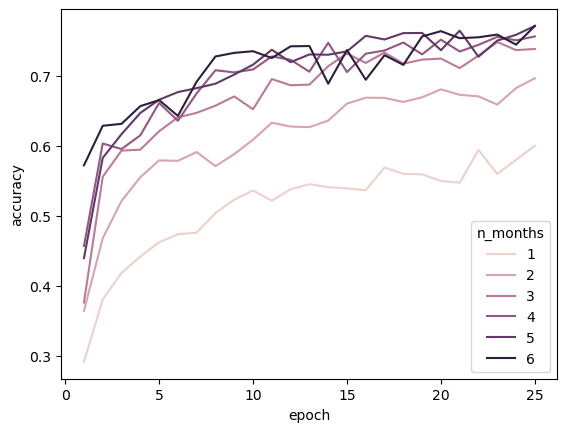

In [16]:
sns.lineplot(data=trf_stats_df, x="epoch", y="accuracy", hue="n_months")

<AxesSubplot: xlabel='n_months'>

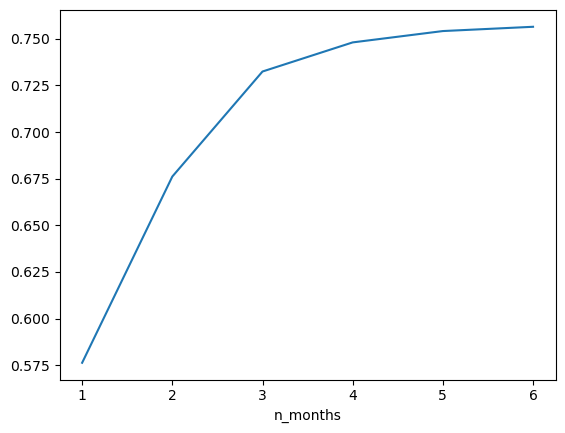

In [23]:
trf_stats_df.loc[trf_stats_df["epoch"] > 20, ].groupby("n_months").agg("mean")["accuracy"].plot()

In [4]:
tempcnn_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(epochs=25,
                       model="tempcnn",
                       n_months=n_months,
                       sequencelength=sequencelength)
    best_model, train_stats = train(args)
    tempcnn_stats.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([10, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.74, testloss 0.95, accuracy 0.72, earliness 0.00. classification loss 0.95, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.54, testloss 1.07, accuracy 0.68, earliness 0.00. classification loss 1.07, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.44, testloss 1.04, accuracy 0.71, earliness 0.00. classification loss 1.04, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.39, testloss 1.19, accuracy 0.73, earliness 0.00. classification loss 1.19, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.36, testloss 1.45, accuracy 0.68, earliness 0.00. classification loss 1.45, earliness reward 0.00. early stopping


Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 25: trainloss 0.31, testloss 1.09, accuracy 0.73, earliness 0.00. classification loss 1.09, earliness reward 0.00. early stopping


In [10]:
tempcnn_stats_df = make_stats_df(tempcnn_stats)
tempcnn_stats_df.head()

,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward,n_months
0,1,1.411728,1.567105,0.488216,0.618615,0.467506,0.479330,0.418691,0.0,1.567105,0.0,1
1,2,1.106532,1.521695,0.503357,0.611987,0.484003,0.490698,0.414875,0.0,1.521695,0.0,1
2,3,1.012419,1.445810,0.549835,0.620397,0.488586,0.490612,0.474629,0.0,1.445810,0.0,1
3,4,0.962360,1.470501,0.513364,0.632703,0.544994,0.524464,0.450406,0.0,1.470501,0.0,1
4,5,0.934160,1.596578,0.461093,0.570192,0.490165,0.436423,0.385426,0.0,1.596578,0.0,1


<AxesSubplot: xlabel='epoch', ylabel='accuracy'>

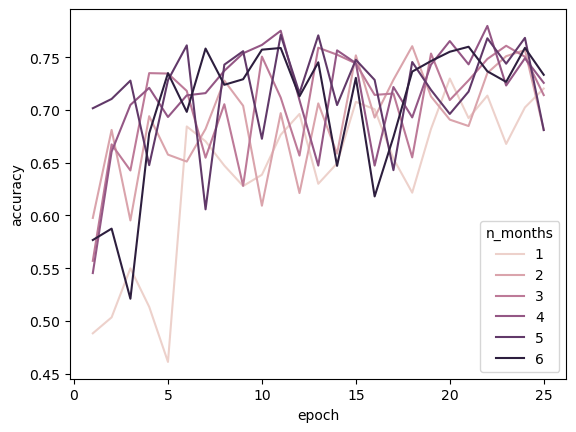

In [17]:
sns.lineplot(data=tempcnn_stats_df, x="epoch", y="accuracy", hue="n_months")

<AxesSubplot: xlabel='n_months'>

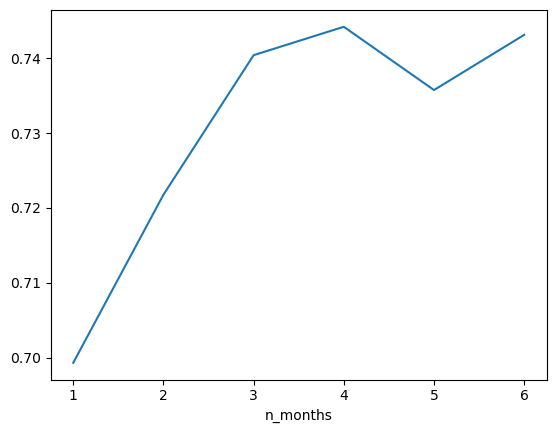

In [22]:
tempcnn_stats_df.loc[tempcnn_stats_df["epoch"] > 20, ].groupby("n_months").agg("mean")["accuracy"].plot()

In [5]:
earlyrnn_args = TrainConfig(epochs=25,
                   model="earlyrnn",
                   sequencelength=60)
_, earlyrnn_stats = train(earlyrnn_args)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
Total length of data: train=30417, test=7595
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 25: trainloss 3.42, testloss 5.07, accuracy 0.79, earliness 0.43. classification loss 12.92, earliness reward 2.78. early stoppin


In [13]:
ern_stats_df = pd.DataFrame(earlyrnn_stats)
ern_stats_df.head()

,epoch,trainloss,testloss,accuracy,precision,recall,fscore,kappa,earliness,classification_loss,earliness_reward
0,1,9.797476,8.443903,0.498881,0.460012,0.359970,0.366357,0.402288,0.187862,18.254560,1.366757
1,2,7.017492,7.029847,0.597103,0.603595,0.466991,0.492615,0.523022,0.258734,16.039881,1.980188
2,3,5.916386,6.335333,0.673338,0.729125,0.532180,0.572152,0.615130,0.316491,14.856997,2.186328
3,4,5.410260,6.247192,0.688348,0.727173,0.637997,0.662712,0.638379,0.315015,14.651064,2.156682
4,5,4.916356,5.757849,0.724292,0.753401,0.633378,0.676254,0.676793,0.339017,13.936202,2.420505


<AxesSubplot: xlabel='epoch'>

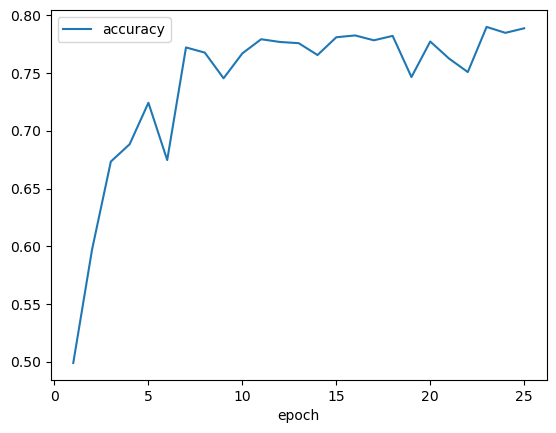

In [18]:
ern_stats_df.plot(x="epoch", y="accuracy")

In [14]:
trf_stats_df.to_csv("trf_stats.csv")
tempcnn_stats_df.to_csv("tempcnn_stats.csv")
ern_stats_df.to_csv("ern_stats.csv")

In [4]:
earlyrnn_args_with_geo = TrainConfig(epochs=25,
                   model="earlyrnn",
                   sequencelength=60,
                   geo=False)
_, earlyrnn_stats_with_geo = train(earlyrnn_args_with_geo)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 27914 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7432 fields
Total length of data: train=27914, test=7432
X shape: torch.Size([60, 12]) y shape: torch.Size([60])


  0%|                                                                                                                          | 0/25 [00:00<?, ?it/s]


RuntimeError: Given normalized_shape=[10], expected input with shape [*, 10], but got input of size[128, 60, 12]

In [ ]:
ern_stats_with_geo_df = pd.DataFrame(earlyrnn_stats_with_geo)
ern_stats_with_geo_df.head()